https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

https://liferay.de.dariah.eu/tatom/topic_model_visualization.html

In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
import math
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
inputs = os.path.join("..", "inputs")
outputs = os.path.join('..','outputs')

In [3]:
sql_db = os.path.join(inputs, 'cpdoc_as.sqlite')
conn = sqlite3.connect(sql_db)
cur = conn.cursor()

topic_doc = pd.read_sql_query("SELECT * FROM topic_doc", conn)

# build heatmap for docs and topics
needs to filter number of docs to fit heatmap:
* by 20 largest scores per topic: needs to argue that
    * data was filtered to <20% of total, but this would be the relevant data. Could argue that delivery of a better granularity cannot be in the scope of this thesis and will be left to later developments.
    * targets are domain specialists instead of main users, which implies that we want specialists to focus mostly on topics.
* by score threshold: 
    * Topic Africa has med=0.15 and min=0.12, 
    * Topic Latin America has med=0.32 and min=0.24, 
    * EUA 0.37 and 0.29
* Alternative???

long to wide: https://stackoverflow.com/questions/5890584/how-to-reshape-data-from-long-to-wide-format

* reordenar tópicos considerando: dos 20 docs principais por tópico, qual a média de score.
* renomear os tópicos de acordo com a nova ordem
* construir heatmap de score entre documentos e tópicos

reorder topics according to median score

In [4]:
#%%timeit
#sort by topic_score to capture 20 docs with greatest score per topic
topic_doc_sorted = topic_doc.sort_values(by=['topic_id', 'topic_score'], ascending=[True, False])

#get list of docs with greatest score per topic (20 docs for each topic)
docs_filtered = []
topic_doc_sorted['median'] = 0
for i in range(100):
    df_fraction = list(topic_doc_sorted[topic_doc_sorted['topic_id'] == i].head(20)['doc_id'])
    docs_filtered.extend(df_fraction)
    topic_doc_sorted.loc[topic_doc_sorted.topic_id == i, 'median'] = sum(list(topic_doc_sorted[topic_doc_sorted['topic_id'] == i].iloc[9:11].topic_score))/2
#     break
    
#remove duplicates (docs which are important for more than 1 topic)
docs_filtered = list(set(docs_filtered))

#reorder topics according to median score of 20 main docs
topic_doc_sorted = topic_doc_sorted.sort_values(by=['median'], ascending=[False])

In [5]:
# df_filtered = topic_doc_sorted[topic_doc_sorted['doc_id'].isin(docs_filtered)] # filter to only important docs
df_filtered = topic_doc_sorted.copy()
df_filtered.rename(columns={'doc_id': 'Documentos', 'topic_id': 'Topicos'},inplace=True)

print('Length of filtered dataframe:', len(df_filtered))
df_filtered.head()

Length of filtered dataframe: 114506


,Documentos,Topicos,topic_score,median
14401,ag_1974.03.00-1_doc_III-44,9,0.901569,0.749498
95083,rb_1974.02.06_doc_I-34,9,0.046395,0.749498
13973,ag_1974.03.00-1_doc_II-80,9,0.046830,0.749498
48312,d_1974.03.26_doc_II-64,9,0.046778,0.749498
10445,ag_1974.01.22_doc_V-1,9,0.046745,0.749498


rename topics according to order of median score

In [6]:
df_filtered['topics_renamed'] = -1

topics_list = []
for i in list(df_filtered['Topicos']):
    if i not in topics_list: topics_list.append(i)

for i,topic in enumerate(topics_list):
    df_filtered.loc[df_filtered['Topicos'] == topic, 'topics_renamed'] = i
df_filtered['Topicos'] = df_filtered['topics_renamed']
df_filtered.drop('topics_renamed', axis=1, inplace=True)

In [7]:
df_wide=df_filtered.pivot(index='Documentos', columns='Topicos', values='topic_score')
df_wide.fillna(0, inplace=True)
df_wide.head()

Topicos,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Documentos,,,,,,,,,,,,,,,,,,,,,
ag_1973.11.20_doc_I-100,0.167559,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
ag_1973.11.20_doc_I-101,0.215000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
ag_1973.11.20_doc_I-102,0.140936,0.0,0.0,0.0,0.0,0.0,0.213873,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
ag_1973.11.20_doc_I-103,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
ag_1973.11.20_doc_I-104,0.432459,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0505,0.0,0.0,0.0,0.0,0.0


##### choosing a white-to-black scale, as Asla suggested that it is more informative. Also, for printing, it won't have the risk of losing information
to manipulate the colorbar: 
* https://stackoverflow.com/questions/35024475/seaborn-heatmap-key-words
* https://stackoverflow.com/questions/47916205/seaborn-heatmap-move-colorbar-on-top-of-the-plot
* documentation: https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html?highlight=colorbar#matplotlib.figure.Figure.colorbar

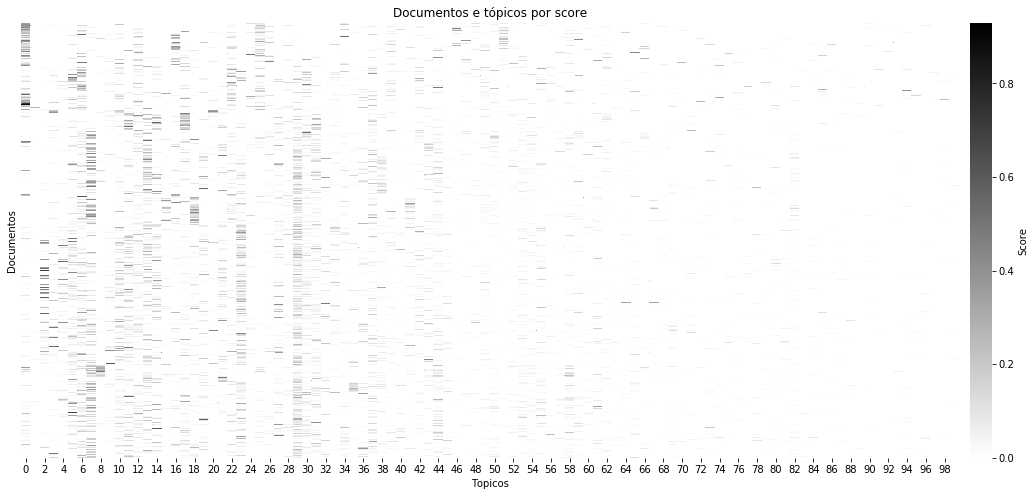

In [12]:
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Documentos e tópicos por score')
sns.heatmap(df_wide, cmap="gist_gray_r", xticklabels=2, yticklabels=False, cbar_kws={'label': 'Score', 'pad': 0.01})
plt.savefig(os.path.join(outputs,'heatmap.png'))

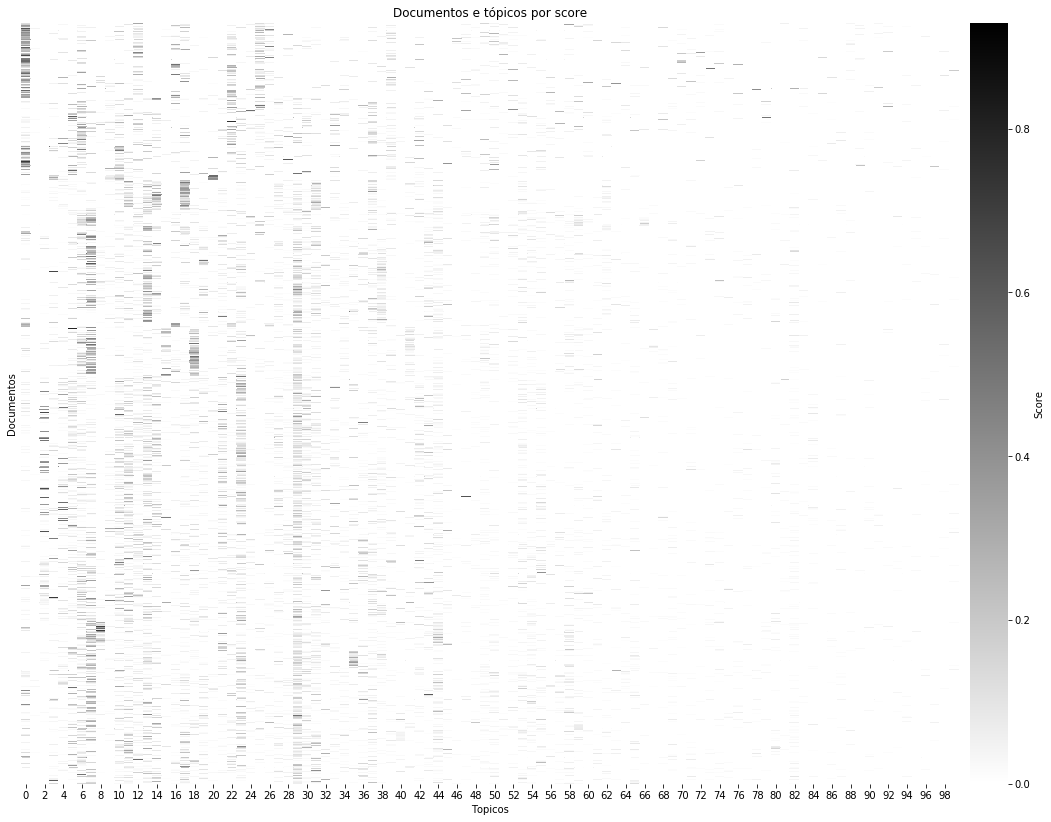

In [13]:
plt.figure(figsize=(20, 14))
ax = plt.axes()
ax.set_title('Documentos e tópicos por score')
sns.heatmap(df_wide, cmap="gist_gray_r", xticklabels=2, yticklabels=False, cbar_kws={'label': 'Score', 'pad': 0.01})
plt.savefig(os.path.join(outputs,'heatmap-paper.png'), dpi=300)

number of y labels = 43

# rename topics on SQL
They need to correspond to the visualization of the heatmap

atention to topic names being dfferent now!!!!

In [14]:
sql_db = os.path.join(inputs, 'cpdoc_as.sqlite')
conn = sqlite3.connect(sql_db)
cur = conn.cursor()


cur.execute("DROP TABLE IF EXISTS topics")
cur.execute('''CREATE TABLE IF NOT EXISTS topics
           (id SMALLINT(6) PRIMARY KEY, name VARCHAR(250), old_id SMALLINT(6)
           DEFAULT NULL)
           ;''')

topic_name = ''
for i, old_id in enumerate(topics_list):
    query = "INSERT INTO topics VALUES (?, ?, ?)"
    cur.execute(query, (i, topic_name, old_id))

conn.commit()
conn.close()

In [34]:
topics_list[:20]

[9, 84, 29, 32, 28, 0, 35, 44, 54, 77, 82, 75, 6, 81, 99, 49, 11, 42, 17, 56]